## 5장: 레이블이 없는 데이터를 활용한 사전 훈련

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow"]

for p in pkgs:
    print(f"{p} 버전: {version(p)}")

matplotlib 버전: 3.10.7
numpy 버전: 1.26.4
tiktoken 버전: 0.11.0
torch 버전: 2.6.0
tensorflow 버전: 2.20.0


### 5.1.1 GPT를 사용해 텍스트 생성하기

In [2]:
import torch
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 어휘 사전 크기
    "context_length": 256, # 짧은 문맥 길이 (원본 길이: 1024)
    "emb_dim": 768,        # 임베딩 차원
    "n_heads": 12,         # 어텐션 헤드 개수
    "n_layers": 12,        # 층 개수
    "drop_rate": 0.1,      # 드롭아웃 비율
    "qkv_bias": False      # 쿼리-키-값 생성시 편향 사용 여부
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [3]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 배치 차원을 삭제합니다.
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.1.2 텍스트 생성 손실 계산하기
- 두 개의 훈련 샘플(행)에 대한 토큰 ID를 담고 있는 inputs 텐서가 있다고 가정해 보죠
- inputs에 해당하는 targets은 모델이 생성해야 될 토큰 ID를 담고 있습니다.
- 2장에서 데이터 로더를 구현할 때 설명했듯이 targets은 inputs에서 한 토큰씩 앞으로 이동한 것입니다.

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- inputs을 모델에 주입하면 각각 세 개의 토큰으로 구성된 두 개의 입력 샘플에 대한 로짓 벡터를 얻습니다.
- 각각의 토큰은 어휘 사전 크기에 해당하는 50,257 차원의 벡터입니다.
- 소프트맥스 함수를 적용하여 로짓 텐서를 확률 점수를 담고 있는 동일 차원의 텐서로 바꿀 수 있습니다.

In [5]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # 어휘 사전의 각 토큰에 대한 확률
print(probas.shape) # 크기: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 이전 장에서 설명했듯이 argmax함수를 적용하여 확률 점수를 토큰 ID (인덱스)로 바꿀 수 있습니다.
- 앞의 소프트맥스 함수는 각 토큰에 대해서 50,257차원의 벡터를 생성합니다. argmax 함수는 이 벡터에서 가장 높은 확률을 가진 위치를 반환합니다. 이것이 주어진 토큰에 대한 예측 토큰의 아이디입니다.
- 배치에는 각각 세개의 토큰으로 구성된 두 개의 입력 샘플이 있으므로 2x3크기의 예측 토큰을 얻습니다.

In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("토큰 ID:\n", token_ids)

토큰 ID:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 이 토큰을 디코딩하면 모델이 예측해야 할 토큰, 즉 타겟 토큰과 매우 다른 것을 알 수 있습니다.

In [7]:
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(targets[0], tokenizer)}")
print(f"첫 번째 샘플의 출력: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

첫 번째 샘플의 타깃:  effort moves you
첫 번째 샘플의 출력:  Armed heNetflix


- 타깃 인덱스에 해당하는 토큰 확률은 다음과 같습니다

In [8]:
targets[0]

tensor([3626, 6100,  345])

- 각 입력 샘플 토큰에 대한 정답 위치의 확률을 확인합니다

In [9]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("텍스트 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("텍스트 2:", target_probas_2)

텍스트 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
텍스트 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 확률이 1에 가까워지도록 이 값들을 최대화하는 것이 목표입니다.
- 수학적 최적화에서는 확률 점수 자체를 최대화하는 것보다 확률 점수의 로그를 최대화하는 것이 쉽습니다.

In [10]:
# 토큰 확률의 로그를 계산합니다.
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [11]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 모델 가중치를 최적화하여 평균 로그 확률을 가능한 크게 만드는 것이 목표입니다.
- 로그때문에 가장 큰 가능한 값은 0이며, 현재는 0에서부터 멀리 떨어져 있습니다.

- 딥러닝에서는 평균 로그 확률을 최대화하는 것 대신에 음의 평균 로그 확률을 최소화하는 것이 일반적입니다. 이 예제의 경우 -10.7940를 최대화하여 0에 가깝게 만드는 것 대신에 10.7940을 최소화하여 0에 가깝게 만듭니다.
- -10.7940의 음수 값, 즉, 10.7940을 딥러닝에서는 크로스 엔트로피 손실이라고 부릅니다

In [12]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- cross_entropy 함수를 적용하기 전에 로짓과 타깃의 크기를 확인해야 합니다

In [13]:
# 로짓의 크기는 (batch_size, num_tokens, vocab_size) 입니다.
print("logits size: ", logits.shape)

# 타깃의 크기의 (batch_size, num_tokens) 입니다.
print("target size: ", targets.shape)

logits size:  torch.Size([2, 3, 50257])
target size:  torch.Size([2, 3])


- 파이토치의 cross_entropy함수를 위해 배치 차원을 기준으로 합쳐서 텐서를 펼쳐야 합니다.

In [14]:
# (batch, num_token, vocab_size) -> (total_tokens, vocab_size) vocab_size는 예측 벡터
# 모든 샘플, 모든 토큰 위치에 대한 예측을 하나의 큰 목록으로 간주, 각 행은 vocab_size 크기의 예측 벡터 
logits_flat = logits.flatten(0, 1) 
# targets는 (batch, num_tokens) 에는 vocab 내의 정답 인덱스
targets_flat = targets.flatten() # total_tokens 갯수의 정답 인덱스

print("flat logits: ", logits_flat.shape)
print("flat targets: ", targets_flat.shape)

flat logits:  torch.Size([6, 50257])
flat targets:  torch.Size([6])


In [15]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### 5.1.3 훈련 세트와 검증 세트의 손실 계산하기

In [16]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode("utf-8")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 다운로드한 텍스트를 확인하기 위해 처음과 끝에서 100개의 문자를 출력

In [17]:
print(text_data[:99])
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("characters: ", total_characters)
print("tokens: ", total_tokens)

characters:  20479
tokens:  5145


In [19]:
from previous_chapters import create_dataloader_v1

# 훈련 세트 비율
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [20]:
# 유효성 검사: context_length: 256
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("훈련 데이터 로더에 토큰이 충분하지 않습니다. "
          "`GPT_CONFG_124M['contxt_length']`를 낮추거나 "
          "`train_ratio`를 증가시키세요")
    
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("훈련 데이터 로더에 토큰이 충분하지 않습니다. "
        "`GPT_CONFIG_124M['context_length']`를 낮추거나 "
        "`training_ratio`를 증가시키세요.")

- 데이터가 올바르게 로드되었는 지 확인

In [21]:
print("훈련 데이터 로더:")
for x , y in train_loader:
    print(x.shape, y.shape)
    
print("\n검증 데이터 로더:")
for x , y in val_loader:
    print(x.shape, y.shape)

훈련 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

검증 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])


- 토큰 크기가 예상 범위 안에 있는 지 추가로 확인합니다.

In [22]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()
    
val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()
    
print("훈련 토큰 수:", train_tokens)
print("검증 토큰 수:", val_tokens)
print("모든 토큰 수:", train_tokens + val_tokens)

훈련 토큰 수: 4608
검증 토큰 수: 512
모든 토큰 수: 5120


- 주어진 배치에서 크로스 엔트로피 손실을 계산하는 유틸리티 함수를 작성합니다.
- 또한 데이터 로더에서 사용자가 지정한 배치 개수 만큼 추출하여 손실을 계산하는 두 번째 유틸리티 함수를 구현합니다.

In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [24]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    toatl_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)  # num_batch가 지정되지 않으면 모든 배치를 순회합니다.
    else:
        # num_batches가 데이터 로더에 있는 배치 개수보다 크면
        # 배치 횟수를 데이터 로더에 있는 총 배치 개수로 맟춥니다.
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            toatl_loss += loss
        else:
            break
    return toatl_loss / num_batches

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("훈련 손실:", train_loss)
print("검증 손실:", val_loss)

훈련 손실: tensor(10.9876, device='cuda:0')
검증 손실: tensor(10.9811, device='cuda:0')


## 5.2 LLM 훈련하기

In [26]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 손실과 지금까지 처리한 토큰 수를 추적하기 위해 리스트를 초기화합니다.
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    # 메인 훈련 루프를 시작합니다.
    for epoch in range(num_epochs):
        model.train()       # 모델을 훈련 모드로 설정합니다.
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()      # 이전 배치 반복에서 얻은 손실과 gradient를 초기화 합니다
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()             # 손실의 gradient를 계산합니다.
            optimizer.step()           # loss gradient를 사용하여 모델 가중치를 update합니다.
            tokens_seen += input_batch.numel()
            global_step += 1
            
            # 추가적인 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"에포크 {epoch+1} (Step {global_step:06d}): "
                      f"훈련 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")
        
        # 각 에포크 후에 샘플 텍스트를 출력합니다.
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded= text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))      # 간결한 출력 포맷을 위해
    model.train()

- 위에 정의한 훈련 함수로 LLM을 훈련해 보죠. 

In [27]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

에포크 1 (Step 000000): 훈련 손실 9.817, 검증 손실 9.928
에포크 1 (Step 000005): 훈련 손실 7.920, 검증 손실 8.336
Every effort moves you,,,,,,,,,,,,.                                     
에포크 2 (Step 000010): 훈련 손실 6.585, 검증 손실 7.044
에포크 2 (Step 000015): 훈련 손실 5.985, 검증 손실 6.593
Every effort moves you, the, and, the, the, the, the, the. ", the,,, the, and, the, of the, the, the,, the, the,, the, and,,,,, of
에포크 3 (Step 000020): 훈련 손실 15.506, 검증 손실 15.669
에포크 3 (Step 000025): 훈련 손실 5.595, 검증 손실 6.451
Every effort moves you, and to the picture. Gis. G, and I had. I had, and I had. Gis, and, and. I had. I had to the his-- the ", and, and--. Gis, and
에포크 4 (Step 000030): 훈련 손실 5.049, 검증 손실 6.346
에포크 4 (Step 000035): 훈련 손실 4.606, 검증 손실 6.237
Every effort moves you, and I had a--I was a--I had a of the a of the picture--I--and, I had to me, I had to the picture to me, I had been, I had a--and, I had a
에포크 5 (Step 000040): 훈련 손실 4.110, 검증 손실 6.330
Every effort moves you know it was his a little a--I was his picture

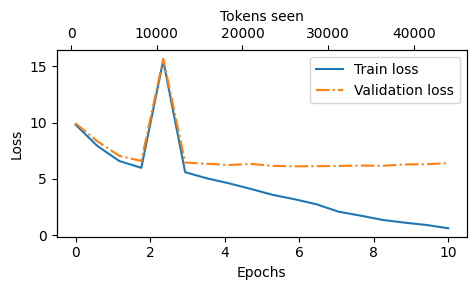

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    
    # 에포크에 대한 훈련 손실과 검증 손실의 그래프를 그립니다.
    ax1.plot(epochs_seen, train_losses, label="Train loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))      # only show integer lables on x-axis
    
    # 처리한 토큰 수에 대한 두 번째 x축을 만듭니다
    ax2 = ax1.twiny()       # y축을 공유하는 두 번째 x축을 만듭니다
    ax2.plot(tokens_seen, train_losses, alpha=0)    # 눈금을 정렬하기 위해 투명한 그래프를 만듭니다
    ax2.set_xlabel("Tokens seen")
    
    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

train_losses_cpu = [t.cpu().item() for t in train_losses]
val_losses_cpu = [t.cpu().item() for t in val_losses]

plot_losses(epochs_tensor.cpu(), tokens_seen, train_losses_cpu, val_losses_cpu)

### 5.3 무작위성을 제어하기 위한 디코딩 전략
- 위에서 구현한 GPT모델처럼 작은 LLM의 추론 비용은 비교적 저렴합니다. 따라서, 훈련에 GPU를 사용했더라도 추론에서는 GPU를 사용할 필요가 없습니다.
- 이전 장에서 만든 generate_text_simple 함수를 사용해 한 번에 하나의 단어(또는 토큰)씩 새로운 텍스트를 생성할 수 있습니다.


In [29]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 텍스트\n", token_ids_to_text(token_ids, tokenizer))


출력 텍스트
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




#### 5.3.1 온도 스케일링
- 이전에는 torch.argmax 를 사용해 항상 가장 높은 확률은 가진 토큰을 다음 토큰으로 샘플링했습니다.
- 다양성을 추가하기 위해 확률 분포에서 샘플링하도록 torch.multinormal(probs, num_samples=1)을 사용해 토큰을 샘플링할 수 있습니다.

In [30]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = { v: k for k, v in vocab.items()}

# 입력이 "every effort moves you"이고,
# LLM이 다음 토큰을 위해 아래와 같은 로짓을 반환했다고 가정해 보죠
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# 생성될 토큰은 다음과 같습니다
print(inverse_vocab[next_token_id])


forward


In [31]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


- torch.argmax 로 가장 가능성이 높은 토큰을 결정하는 대신에 torch.multinomial(probas, mum_samples=1) 를 사용해 소프트맥스 분포에서
샘플링하여 가장 가능성이 높은 토큰을 결정할 수 있습니다.
- 설명을 위해 원래 소프트맥스 분포에서 1,000번 토큰을 샘플링해 보죠.

In [32]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [ torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- 온도 스케일링으로 분포와 선택과정을 조절할 수 있습니다.
- "온도 스케일링"은 로짓을 0보다 큰 숫자로 나누는 것을 의미합니다.
- 1보다 큰 온도는 소프트맥스 함수를 적용한 후에 더 균등한 토큰 확률 분포를 만듭니다.
- 1보다 작은 온도는 소프트맥스 함수를 적용한 후에 더 결정론적인 분포(더 날카롭거나 뾰족한 분포)를 만듭니다

In [33]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# 온도 값
temperatures = [1, 0.1, 5]

# scale을 조정한 확률 계산
scaled_probas = [ softmax_with_temperature(next_token_logits, T) for T in temperatures]

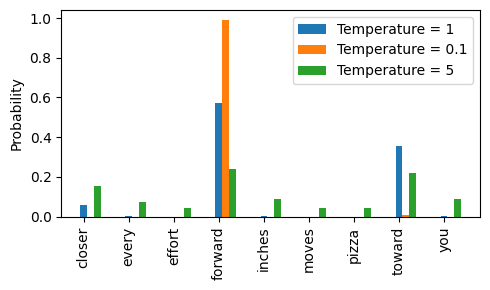

In [34]:
# 그래프 그리기
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i*bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
    
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [35]:
print(scaled_probas)

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03]), tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22]), tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]


#### 5.3.2 탑-k 샘플링
- 높은 온도를 사용하여 출력의 다양성을 증가시키면서 말이 안되는 문장이 생성될 가능성을 낮추기 위해 가장 가능성 있는 상위 k개 
토큰으로 샘플링될 토큰을 제한할 수 있습니다.

In [36]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("탑-k 로짓:", top_logits)
print("탑-k 위치:", top_pos)

탑-k 로짓: tensor([6.7500, 6.2800, 4.5100])
탑-k 위치: tensor([3, 7, 0])


In [37]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [38]:
topK_probas = torch.softmax(new_logits, dim=0)
print(topK_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


#### 5.3.3 텍스트 생성 함수 수정하기
- 이전 두 개의 절에서 온도 스케일링과 탑-k 샘플링을 소개했습니다.
- 두 개념을 사용해 앞서 LLM으로 텍스트를 생성할 때 사용한 generate_sample 함수를 수정해 새로운 generate 함수를 만들어 보자.

In [39]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # for 루프는 이전과 동일합니다. 로짓을 받아 마지막 타임 스텝만 사용합니다.
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 탑-k 샘플링으로 로짓을 필터링합니다.
        if top_k is not None:
            # 탑-k 값만 유지합니다.
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 온도 스케일링을 적용합니다.
        if temperature > 0.0:
            logits = logits / temperature

            # 소프트맥스 함수를 적용하여 확률을 얻습니다.
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 분포에서 샘플링합니다.
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 온도 스케일링을 사용하지 않는 경우 이전처럼 그리디 샘플링을 사용해 다음 토큰을 선택합니다.
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # eos_id가 지정되어 있고 EoS 토큰을 만나면 생성을 중단합니다.
            break

        # 이전과 동일하게 샘플링된 인덱스를 현재 시퀀스 뒤에 추가합니다.
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [40]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you know began to happen a little wild--I was such not to see her


### 5.4 파이토치 모델 로드하고 저장하기

- 파이토치에서는 torch.save 함수를 .state_dict() 메서드 결과에 적용해 소위 state_dict인 모델 가중치를 저장하는 것이 권장됩니다

In [41]:
torch.save(model.state_dict(), "model.pth")

- 그 다음 모델 가중치를 새로운 GPTModel 클래스 인스턴스에 로드할 수 있습니다.

In [42]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- 일반적인 SGD 대신 Adam이나 AdamW와 같이 적응형 옵티마이저로 LLM을 훈련하는 것이 일반적
- 이런 적응형 옵티마이저는 모델 가중치마다 추가적인 파라미터를 저장합니다. 나중에 사전 훈련을 계속하려면 이 파라미터도 저장하는 것이 맞습니다.

In [43]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [44]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

### 5.5 오픈AI에서 사전 훈련된 가중치 로드하기

In [ ]:
# from gpt_download import download_and_load_gpt2

2025-12-03 07:41:34.057766: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 07:41:34.513705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 07:41:35.750693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 72.2kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.27MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 84.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [04:07<00:00, 2.01MiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 4.94MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 727kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 708kiB/s] 


In [ ]:
# print("설정:", settings)

설정: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [ ]:
# print("파라미터 딕셔너리 키:", params.keys())

파라미터 딕셔너리 키: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
# print(params["wte"])
# print("토큰 임베딩 가중치 텐서의 차원:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
토큰 임베딩 가중치 텐서의 차원: (50257, 768)


In [52]:
# 딕셔너리로 모델 설정을 저장합니다.
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# 기본 설정을 특정 값으로 업데이트합니다.
model_name = "gpt2-small (124M)"  # 모델 이름
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [53]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"크기가 다릅니다. left: {left.shape}, right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [54]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

In [55]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I
